# Instruction to lab work # 1: "Playing with a single perceptron & various boundary functions"

> Student name    - Volodymyr

> Student surname - Donets

> Group           - KU-31


# Tasks of the work

0. Set your student id number and used it as random seed for getting unique values to you.
1. Select a few (2 or more) data entries, most comfortable to you (from list of proposed ones or create own kernel for this).
2. Review available activation functions.

## Experiments with single activation function (one decision boundary)

3. Experiment with each available activation (decision boundary) functions. 
4. Answer question, why relu, leaky relu, sigmoid and tanh provide linear separation?)
5. Experiment on various combinations of weights for activation (decision boundary) functions.

## Experiments with multiple activation functions (two decision boundary)

6. Try to build or use selected provided data.
7. Use multiple activation functions to separate data.
8. Build step-by-step complex decision boundary by adding activation (decision boundary) functions. 



In [2]:
STUDENT_ID = 23

# Code part
## Import dependencies

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Help functions

## 1. Kernel functions for data generation.

In [120]:
def gaussian_kernel(center):
    """Factory for a kernel that generates a blob of points."""

    # The returned function takes n_points and generates them around the specified center.
    return lambda n: np.repeat(np.array([center]), n, axis=0)


def circle_kernel(radius, start_angle=0, end_angle=2 * np.pi):
    """Factory for a kernel that generates points on a circle or arc."""

    def _kernel(n):
        theta = np.linspace(start_angle, end_angle, n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T

    return _kernel


def spiral_kernel(rotations=1.5, start_radius=1.0):
    """Factory for a kernel that generates points in a spiral."""

    def _kernel(n):
        theta = np.linspace(0, rotations * 2 * np.pi, n)
        radius = np.linspace(start_radius, start_radius + (rotations * 2), n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T

    return _kernel


def sine_wave_kernel(amplitude=1, frequency=1, x_range=(-5, 5)):
    """Factory for a kernel that generates points along a sine wave."""

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * np.sin(frequency * x)
        return np.vstack([x, y]).T

    return _kernel


def tanh_wave_kernel(amplitude=1, stretch=1, x_range=(-5, 5)):
    """Factory for a kernel that generates points along a tanh (S-shaped) curve."""

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * np.tanh(stretch * x)
        return np.vstack([x, y]).T

    return _kernel


def exponential_kernel(amplitude=1, base=np.e, x_range=(-2, 2)):
    """Factory for a kernel that generates points along an exponential curve."""

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * (base ** x)
        return np.vstack([x, y]).T

    return _kernel


def logarithmic_kernel(amplitude=1, x_range=(0.1, 5)):
    """Factory for a kernel that generates points along a logarithmic curve."""
    if x_range[0] <= 0:
        raise ValueError("The start of x_range for the logarithmic kernel must be > 0.")

    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * np.log(x)
        return np.vstack([x, y]).T

    return _kernel

## 2. Activation functions (decision boundary functions)

In [115]:
def linear_boundary(w1, w2, b):
    """Factory for a linear boundary: w1*x1 + w2*x2 + b = 0."""
    return lambda x1, x2: w1 * x1 + w2 * x2 + b


def relu_boundary(w1, w2, b):
    """Factory for a ReLU activation boundary."""
    # The boundary is where the linear part is 0, but the score is 0 for the entire negative region.
    return lambda x1, x2: np.maximum(0, w1 * x1 + w2 * x2 + b)


def leaky_relu_boundary(w1, w2, b, alpha=0.1):
    """Factory for a Leaky ReLU activation boundary."""

    def _boundary(x1, x2):
        z = w1 * x1 + w2 * x2 + b
        return np.where(z > 0, z, alpha * z)

    return _boundary


def sigmoid_boundary(w1, w2, b):
    """Factory for a sigmoid activation boundary."""

    # The boundary is where the output is 0.5, so we subtract 0.5 from the score.
    def _boundary(x1, x2):
        z = w1 * x1 + w2 * x2 + b
        return 1 / (1 + np.exp(-z)) - 0.5

    return _boundary


def tanh_boundary(w1, w2, b):
    """Factory for a tanh activation boundary."""
    # The boundary is where the output is 0.
    return lambda x1, x2: np.tanh(w1 * x1 + w2 * x2 + b)


def circle_boundary(radius, center=(0, 0)):
    """Factory for a circular boundary."""
    return lambda x1, x2: (x1 - center[0]) ** 2 + (x2 - center[1]) ** 2 - radius ** 2


def sine_boundary(amplitude=1, frequency=1, phase=0):
    """Factory for a sine wave boundary: x2 - A*sin(k*x1 + p) = 0."""
    return lambda x1, x2: x2 - amplitude * np.sin(frequency * x1 + phase)

## 3. Data generation code

In [34]:
def generate_classification_data(n_samples=200, kernels=None, kernel_classes=None,
                                 dispersion=0.2, n_outliers=10, random_seed=42):
    """
    Generates 2D, multi-class data using a flexible kernel-based approach.

    :param n_samples: The total number of data points to generate.
    :param kernels: A list of kernel functions. Each function defines a class and should
                    accept 'n' (number of points) and return an array of shape [n, 2].
    :param kernel_classes: A list of integers mapping each kernel to a class label.
                           Its length must match the length of `kernels`. If None, each kernel
                           is assigned a unique class (e.g., [0, 1, 2, ...]).
    :param dispersion: The standard deviation of Gaussian noise added to each point.
    :param n_outliers: The number of completely random points (noise) to add.
    :param random_seed: A seed for the random number generator for reproducibility.
    :returns: A tuple (X, y) where X is the feature matrix [n_samples, 2]
              and y is the label vector [n_samples,].
    """
    np.random.seed(random_seed)

    if kernels is None:
        kernels = [gaussian_kernel(center=[2, 2]),
                   gaussian_kernel(center=[-2, -2])]

    if kernel_classes is None:
        kernel_classes = list(range(len(kernels)))

    if len(kernels) != len(kernel_classes):
        raise ValueError("The length of 'kernels' and 'kernel_classes' must be the same.")

    n_classes = len(np.unique(kernel_classes))
    n_inliers = n_samples - n_outliers
    if n_inliers <= 0:
        raise ValueError("n_samples must be greater than n_outliers.")

    points_per_kernel = n_inliers // len(kernels)

    X_parts, y_parts = [], []
    for i, kernel in enumerate(kernels):
        class_label = kernel_classes[i]

        # --- THE FIX IS ON THIS LINE ---
        # Ensure the kernel output is float before adding float-based dispersion
        X_class = kernel(points_per_kernel).astype(float)

        X_class += np.random.randn(points_per_kernel, 2) * dispersion
        y_class = np.full(points_per_kernel, class_label)

        X_parts.append(X_class)
        y_parts.append(y_class)

    X_inliers = np.vstack(X_parts)
    y_inliers = np.hstack(y_parts)

    if n_outliers > 0:
        x_min, x_max = X_inliers[:, 0].min(), X_inliers[:, 0].max()
        y_min, y_max = X_inliers[:, 1].min(), X_inliers[:, 1].max()
        padding = (max(x_max - x_min, y_max - y_min)) * 0.1

        X_outliers = np.random.uniform(min(x_min, y_min) - padding,
                                       max(x_max, y_max) + padding,
                                       size=(n_outliers, 2))
        y_outliers = np.random.randint(0, n_classes, size=n_outliers)

        X = np.vstack([X_inliers, X_outliers])
        y = np.hstack([y_inliers, y_outliers])
    else:
        X, y = X_inliers, y_inliers

    permutation = np.random.permutation(X.shape[0])
    X, y = X[permutation], y[permutation]

    return X, y

## 4. Perceptron work visualization

In [88]:
# The combination rule is a logical AND. A point is in the final region
# only if its score is positive for ALL three boundaries.
rule_AND = lambda Z_stack: np.min(Z_stack, axis=0)


def plot_decision_boundary(X, y, decision_functions=None, combination_rule=rule_AND,
                           title="Classification Data", swap_regions=False):
    """
    Plots data and visualizes a complex decision boundary formed by combining multiple functions.

    :param X: The feature matrix, shape (n_samples, 2).
    :param y: The label vector, shape (n_samples,).
    :param decision_functions: A list of functions, where each takes two arguments (x1, x2) and returns a score.
    :param combination_rule: A function that takes a NumPy array of all function scores and returns a single final score grid.
    :param title: The title for the plot.
    :param swap_regions: If True, swaps the colors of the two decision regions.
    """

    plt.style.use('seaborn-v0_8-pastel')  # Using compatible style name
    fig, ax = plt.subplots(figsize=(8, 8))

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, 200),
                           np.linspace(x2_min, x2_max, 200))

    if decision_functions is not None and combination_rule is not None:
        all_Z = np.array([fn(xx1, xx2) for fn in decision_functions])
        final_Z = combination_rule(all_Z)

        # --- THIS IS THE ADDED LOGIC ---
        # If the flag is set, invert the decision scores to swap the regions
        if swap_regions:
            final_Z = -final_Z

        ax.contourf(xx1, xx2, final_Z, levels=[-np.inf, 0, np.inf], colors=['#C4E2FF', '#FFDADA'], alpha=0.6)

        for i, Z in enumerate(all_Z):
            ax.contour(xx1, xx2, Z, levels=[0], colors='gray', linestyles='--', linewidths=1.5)

        ax.contour(xx1, xx2, final_Z, levels=[0], colors='k', linestyles='-', linewidths=2.5)

    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=0.9, zorder=2)

    ax.set_xlabel("Feature 1", fontsize=12)
    ax.set_ylabel("Feature 2", fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    # --- Corrected Legend Creation ---
    handles, _ = scatter.legend_elements()
    num_classes = len(np.unique(y))
    class_labels = [f'Class {i}' for i in range(num_classes)]

    if decision_functions is not None and combination_rule is not None:
        individual_h = plt.Line2D([0], [0], color='gray', linestyle='--', lw=1.5)
        final_h = plt.Line2D([0], [0], color='k', linestyle='-', lw=2.5)
        handles.extend([individual_h, final_h])
        class_labels.extend(['Individual Boundaries', 'Final Boundary'])

    ax.legend(handles=handles, labels=class_labels, loc='upper right', fontsize=11)

    ax.set_xlim(x1_min, x1_max)
    ax.set_ylim(x2_min, x2_max)
    plt.show()

## 5. Examples of generated data

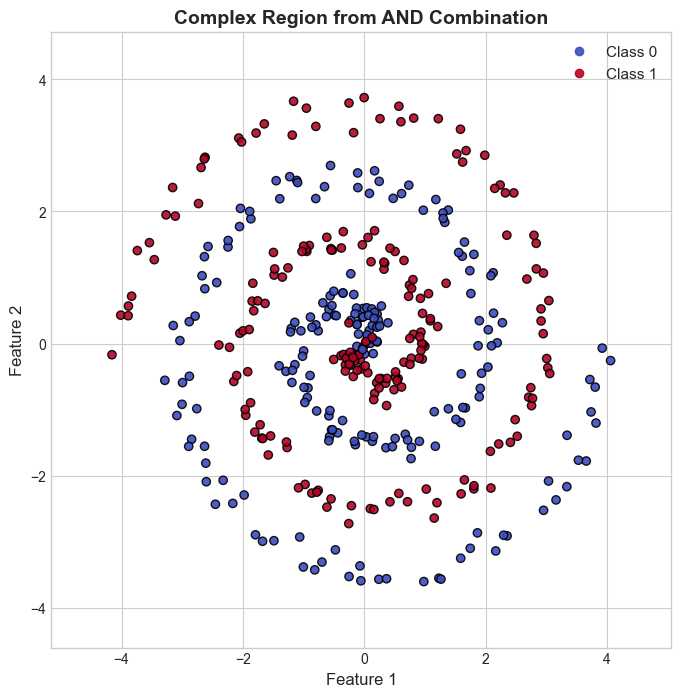

In [124]:
# Spiral data
X_data, y_data = generate_classification_data(
    n_samples=400,
    kernels=[
        spiral_kernel(rotations=2, start_radius=0),
        lambda n: -1 * spiral_kernel(rotations=2, start_radius=0)(n)  # Invert the second spiral
    ],
    kernel_classes=[0, 1],
    dispersion=0.15,
    n_outliers=0,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Complex Region from AND Combination")

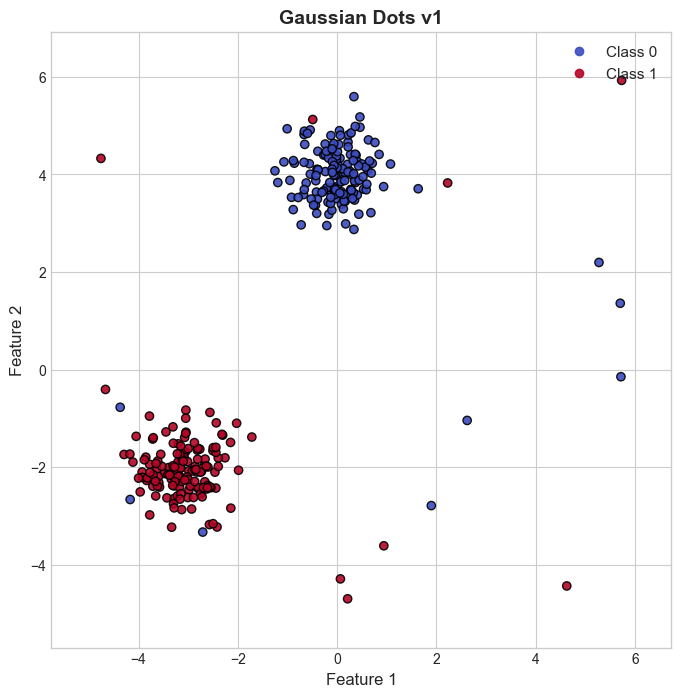

In [127]:
# Gaussian dots data v1
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[gaussian_kernel(center=[0, 4]),
             gaussian_kernel(center=[-3, -2]), ],
    kernel_classes=[0, 1],
    dispersion=0.5,
    n_outliers=20,
    random_seed=STUDENT_ID,
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Gaussian Dots v1")

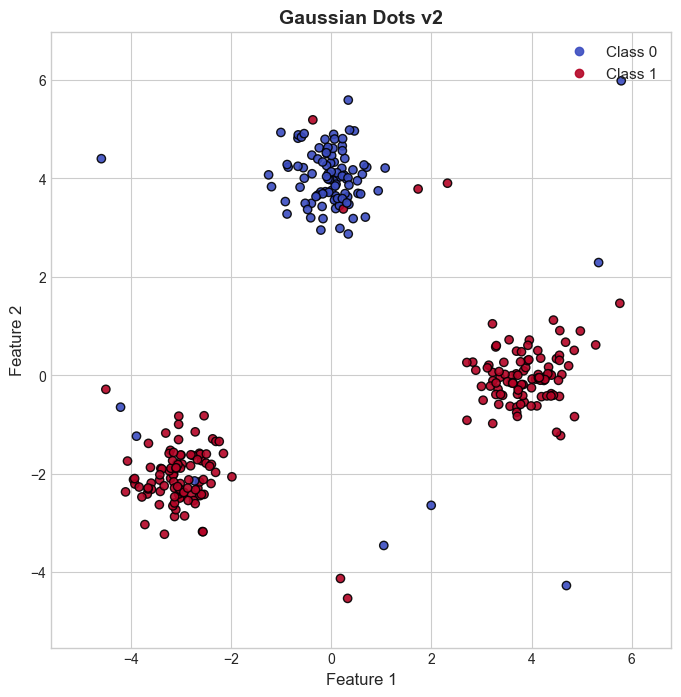

In [129]:
# Gaussian dots data v2
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[gaussian_kernel(center=[0, 4]),
             gaussian_kernel(center=[-3, -2]),
             gaussian_kernel(center=[4, 0]), ],
    kernel_classes=[0, 1, 1],
    dispersion=0.5,
    n_outliers=20,
    random_seed=STUDENT_ID,
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Gaussian Dots v2")

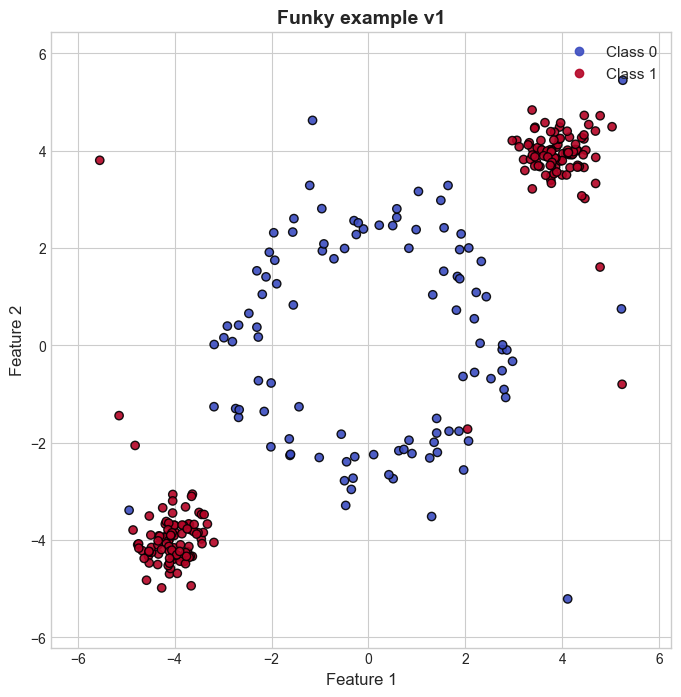

In [161]:
# Funky example v1
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        circle_kernel(radius=2.5),  # This will be for class 0
        gaussian_kernel(center=[-4, -4]),  # This will be part of class 1
        gaussian_kernel(center=[4, 4])  # This will also be part of class 1
    ],
    kernel_classes=[0, 1, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Funky example v1")

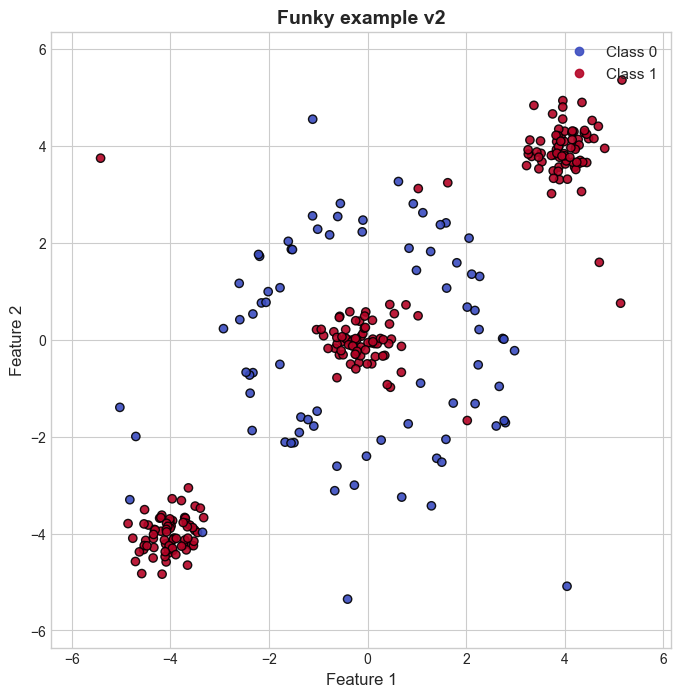

In [160]:
# Funky example v2
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        circle_kernel(radius=2.5),  # This will be for class 0
        gaussian_kernel(center=[-4, -4]),  # This will be part of class 1
        gaussian_kernel(center=[4, 4]),  # This will also be part of class 1
        gaussian_kernel(center=[0, 0]),  # This will also be part of class 1
    ],
    kernel_classes=[0, 1, 1, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Funky example v2")

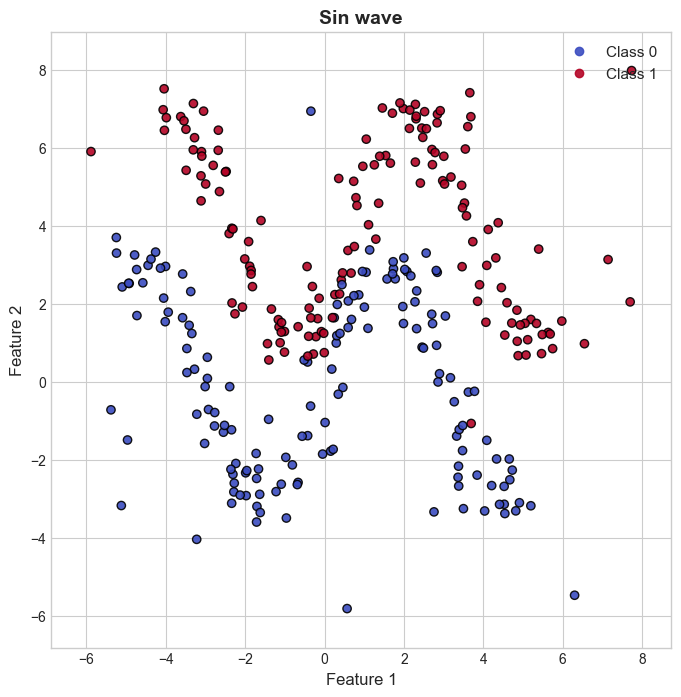

In [162]:
# Sin wave
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        lambda x_: sine_wave_kernel(amplitude=3, frequency=1, x_range=[-5, 5])(x_),
        lambda x_: 4 + sine_wave_kernel(amplitude=-3, frequency=1, x_range=[-8, 2])(x_),
    ],
    kernel_classes=[0, 1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Sin wave")

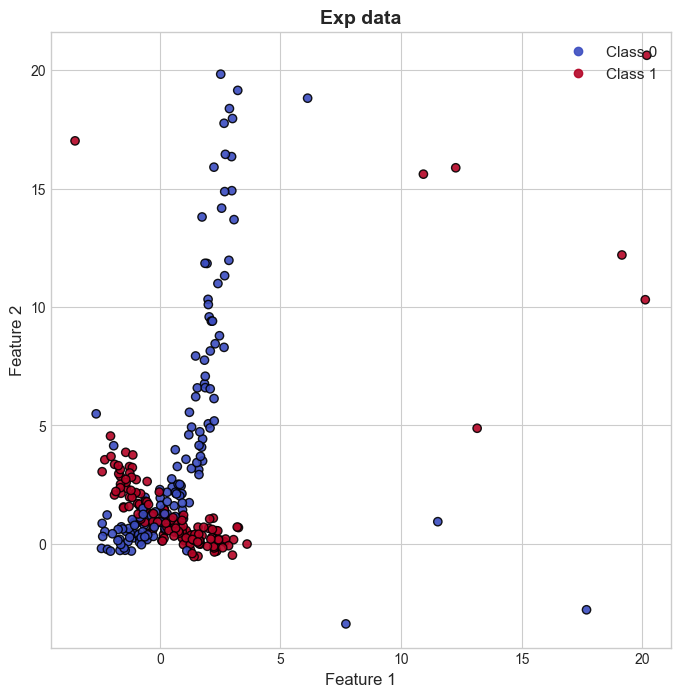

In [165]:
# Exp data
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        # Class 0: Exponential growth
        exponential_kernel(amplitude=1, base=np.e, x_range=(-2, 3)),
        # Class 1: Exponential decay
        exponential_kernel(amplitude=1, base=0.5, x_range=(-2, 3))
    ],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Exp data")

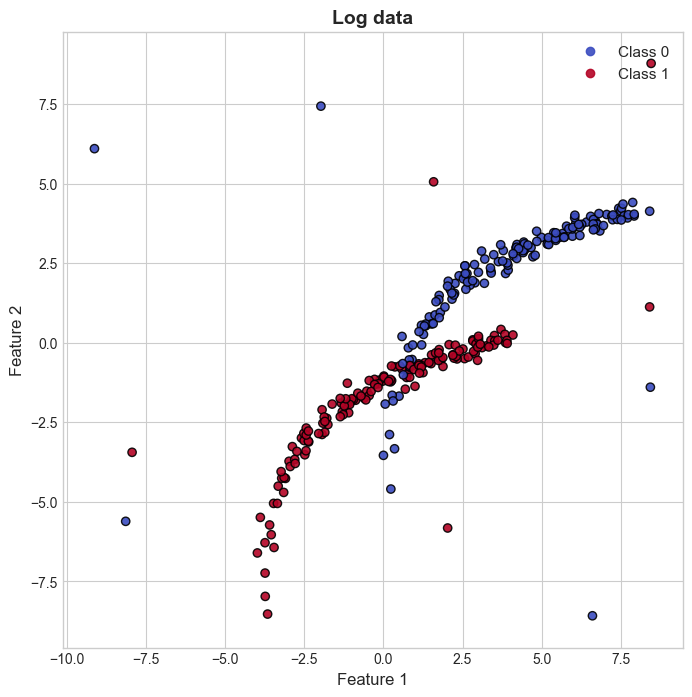

In [166]:
# Logarithmic data
X_data, y_data = generate_classification_data(
    n_samples=300,
    kernels=[
        # Class 0: A standard log curve
        logarithmic_kernel(amplitude=2, x_range=(0.1, 8)),
        # Class 1: Another log curve, shifted down
        lambda n: logarithmic_kernel(amplitude=2, x_range=(0.1, 8))(n) - 4
    ],
    dispersion=0.2,
    n_outliers=10,
    random_seed=STUDENT_ID
)


# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Log data")

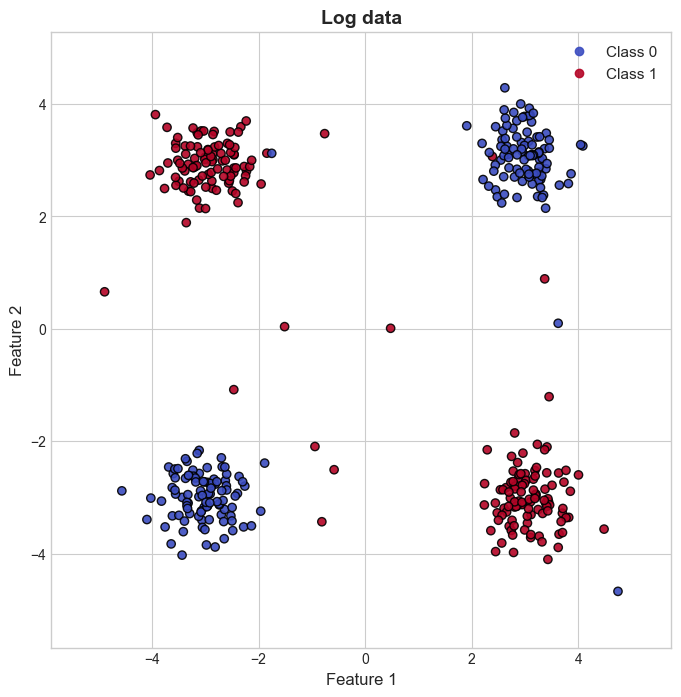

In [168]:
kernels_xor = [
    gaussian_kernel(center=[3, 3]),  # Top-right, Class 0
    gaussian_kernel(center=[-3, -3]),  # Bottom-left, Class 0
    gaussian_kernel(center=[-3, 3]),  # Top-left, Class 1
    gaussian_kernel(center=[3, -3])  # Bottom-right, Class 1
]

# Map the kernels to the two classes
classes_xor = [0, 0, 1, 1]

# Generate and plot the data
X_data, y_data = generate_classification_data(
    n_samples=400,
    kernels=kernels_xor,
    kernel_classes=classes_xor,
    dispersion=0.4,
    n_outliers=20,
    random_seed=101
)

# Plotting generated data
plot_decision_boundary(X_data, y_data,
                       decision_functions=None,
                       title="Log data")

## 6. Examples of using a single decision boundary

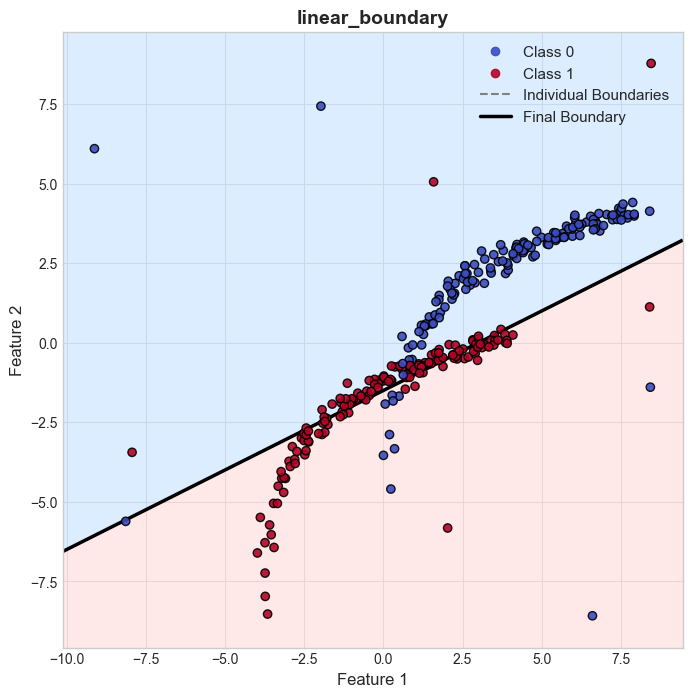

In [167]:
plot_decision_boundary(X_data, y_data,
                       decision_functions=[linear_boundary(-1, 2, 3)],
                       title="linear_boundary",
                       swap_regions=True)  # Set the flag to swap sides

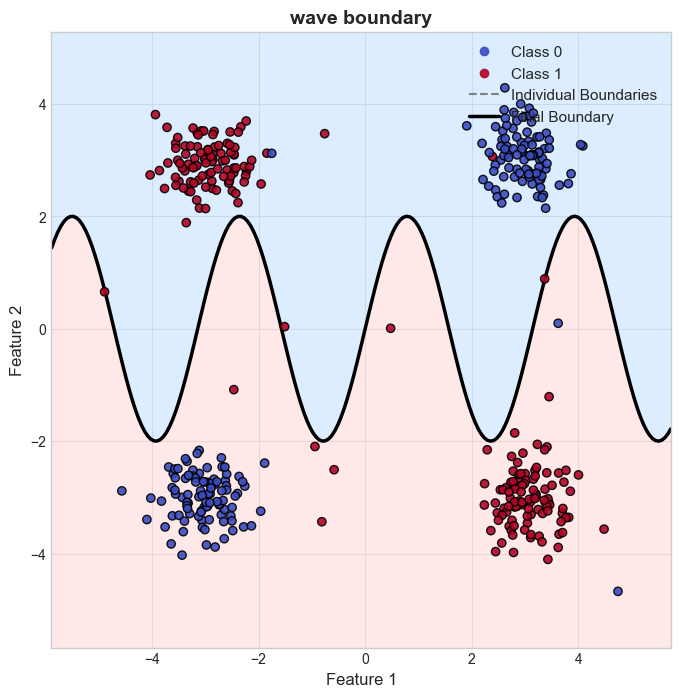

In [169]:
plot_decision_boundary(X_data, y_data,
                       decision_functions=[lambda x1, x2: x2 - np.sin(x1 * 2) * 2],
                       title="wave boundary",
                       swap_regions=True)  # Set the flag to swap sides

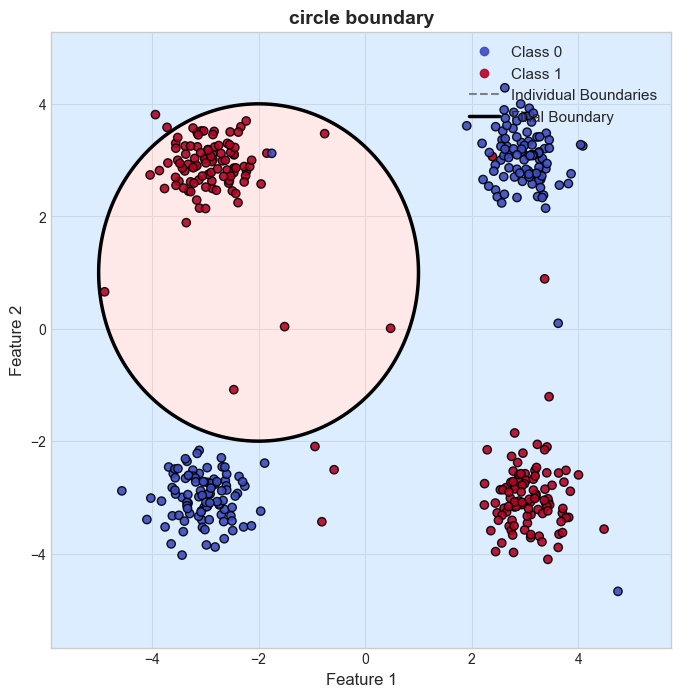

In [170]:
plot_decision_boundary(X_data, y_data,
                       decision_functions=[circle_boundary(radius=3, center=[-2, 1]),],
                       title="circle boundary",
                       swap_regions=True)  # Set the flag to swap sides

## 7. Examples of using multiple decision boundary

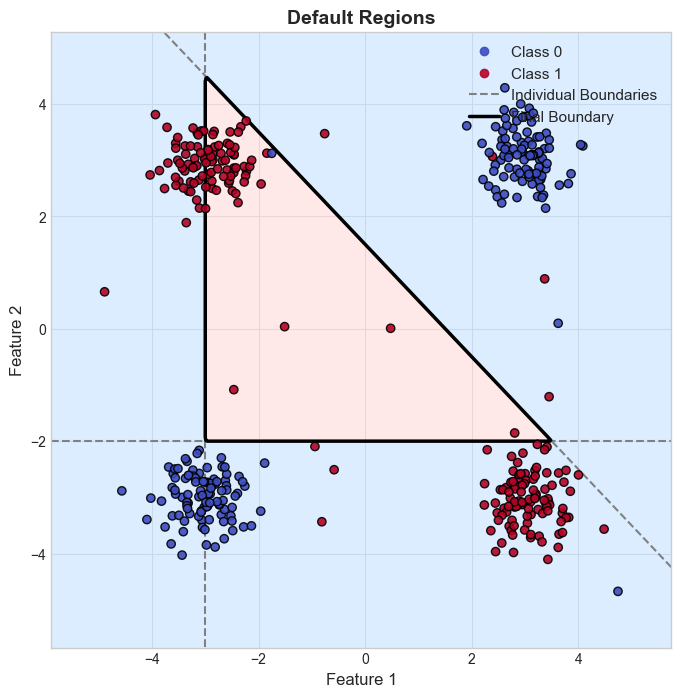

In [174]:
# Assuming generate_classification_data and the three boundary functions are defined
boundary_bottom = lambda x1, x2: x2 + 2.0
boundary_left = lambda x1, x2: x1 + 3.0
boundary_right = lambda x1, x2: -x1 - x2 + 4.0
rule_AND = lambda Z_stack: np.min(Z_stack, axis=0)
decision_funcs = [boundary_bottom, boundary_left, boundary_right]

# --- 1. Default Behavior (swap_regions=False) ---
plot_decision_boundary(X_data, y_data,
                       decision_functions=[linear_boundary(0, 1, 2),
                                           linear_boundary(1, 0, 3),
                                           linear_boundary(-1, -1, 1.5)],
                       combination_rule=rule_AND,
                       title="Default Regions")

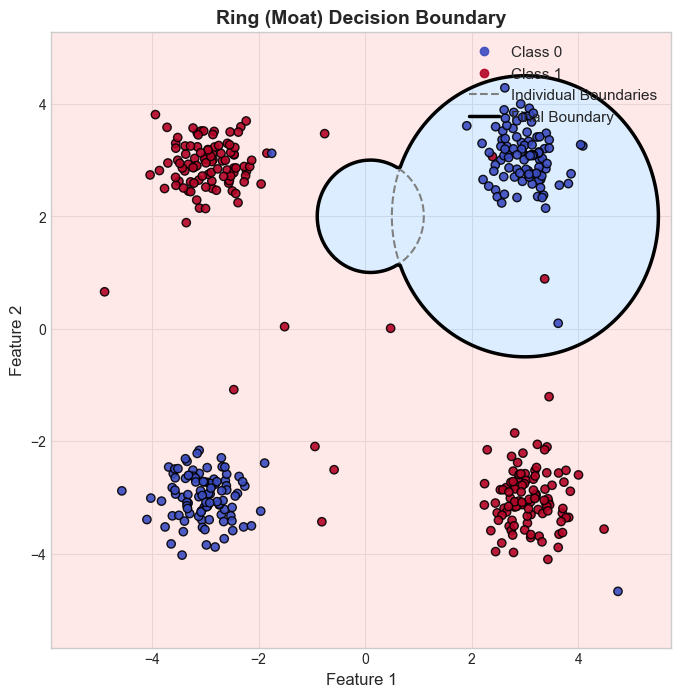

In [178]:
plot_decision_boundary(X_data, y_data,
                       decision_functions=[circle_boundary(1, (0.1, 2)),
                                           circle_boundary(2.5, (3, 2)),],
                       combination_rule=rule_AND,
                       title="Ring (Moat) Decision Boundary")

## Experiments and task examples

In [ ]:
# do your experiments here

# Conclusions on work